In [1]:
README = """
* Use NLTK for tokenizing input - https://www.nltk.org/
* Word2Vec for Embedding vector
* Use Resnet-18
* Use RNN
"""

In [119]:
import pandas as pd
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, Flatten, SimpleRNN,Reshape, Dense, Input, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array 
import nltk
from tqdm import tqdm
import numpy as np
import cv2
from keras.utils import to_categorical
import time
from keras.preprocessing.sequence import pad_sequences 
import matplotlib.pyplot as plt
import cv2

In [3]:
# Loading the Data

data = pd.read_csv("../data/flickr8k_dataset_kaggle/captions.txt")
print(f"num of examples {len(data)}")

data.head()

num of examples 40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [4]:
## Tokenizing the sentences, and added <START> and <STOP> Tokens. 

tokenized_sentences = list()

for i in range(len(data)):
    
    sentence = data.iloc[i]["caption"]
    tokenized_sentence = list() 
    
    tokenized_sentence.append("<START>") 
    tokenized_sentence.extend(sentence.lower().split())
    tokenized_sentence.append("<STOP>")
    
    tokenized_sentences.append(tokenized_sentence)

In [5]:
print(tokenized_sentences[0])

['<START>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<STOP>']


In [6]:
# Computing the num of unique tokens and max length of sentence 
# Possible for the selected data 

tokens = set()
max_len = 0

for token_list in tokenized_sentences:
    max_len = max(len(token_list), max_len)
    for token in token_list:
        tokens.add(token) 

num_tokens = len(tokens)

print(f"Num of tokens : {num_tokens}")
print(f"Max Length of sentence : {max_len}")

Num of tokens : 8920
Max Length of sentence : 40


In [7]:
# Direct and inverse mapping of the token and index

token2ind = dict()
ind2token = dict() 
ind = 1 

for word in tokens:
    token2ind[word] = ind 
    ind2token[ind] = word 
    ind += 1 

In [8]:
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling="avg")
resnet_model.trainable = False

I0000 00:00:1738657941.710840  115685 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [9]:
NUM_EXAMPLES = 1000

In [10]:
folder_path = "../data/flickr8k_dataset_kaggle/Images/"

def load(image_path, size = (224,224)):
    img = load_img(image_path, target_size=size)
    img_array = img_to_array(img) 
    img_array = np.expand_dims(img_array, axis = 0)
    img_array = preprocess_input(img_array) 
    return img_array

def extract_feature(image_path, model): 
    img_array = load(image_path) 
    features = model.predict(img_array, verbose = 0) 
    features = features.flatten()
    return features

In [11]:
image_features = dict() 
for i in tqdm(range(NUM_EXAMPLES)):
    image_name =  data.iloc[i]["image"]
    img_path = folder_path + image_name 
    features = extract_feature(img_path, resnet_model) 
    image_features[image_name] = features

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1738657946.188954  115734 service.cc:148] XLA service 0x7fabfc048b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738657946.189767  115734 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-02-04 08:32:26.302370: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738657946.892533  115734 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1738657950.372432  115734 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████████████████████████████████████████████████

In [28]:
img_features_key = list() 
img_map = list()
input_captions = list() 
output_captions = list() 

for i in tqdm(range(NUM_EXAMPLES)):
    image_name = data.iloc[i]['image']
    img_path = folder_path + image_name
    seq = [token2ind[token] for token in tokenized_sentences[i]]
    for j in range(1, len(tokenized_sentences[i])): 
        in_seq = pad_sequences([seq[:j]], maxlen=max_len)
        out_seq = to_categorical([seq[j]], num_classes=num_tokens)[0]

        img_features_key.append(image_features[image_name])
        img_map.append(image_name)
        input_captions.append(in_seq[0]) 
        output_captions.append(out_seq)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 672.87it/s]


In [14]:
# Creating our embedding_model 

embedding_model = Embedding(input_dim = num_tokens + 1,
                             output_dim = 100)

In [45]:
def get_model():
    # Image Features
    input_x = Input(shape = (2048,))
    x = input_x

    # Caption Embedding
    input_y = Input(shape=(max_len,)) 
    y = embedding_model(input_y) 
    y = SimpleRNN(256)(y) 

    output = Concatenate()([x,y]) 
    output = Dense(256, activation = "relu")(output)
    output = Dense(num_tokens, activation = "softmax")(output) 

    model = Model(inputs = [input_x, input_y], outputs = output)  
    
    return model
    
caption_model = get_model()

In [46]:
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 100)   │    892,100 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_1        │ (None, 256)       │     91,392 │ embedding[1][0]   │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2304)      │          0 │ input_layer_3[0]… │
│ (Concatenate)       │                   │            │ simple_rnn_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    590,080 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8920)      │  2,292,440 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,866,012 (14.75 MB)

 Trainable params: 3,866,012 (14.75 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
img_features_key[0].shape

(2048,)

In [18]:
print(len(img_features_key))
print(img_features_key[0].shape)

print(len(input_captions)) 
print(input_captions[0].shape) 

print(len(output_captions))
print(output_captions[0].shape)

12954
(2048,)
12954
(40,)
12954
(8920,)


In [51]:
# compiling the model

caption_model.compile(
    loss = "categorical_crossentropy",
    optimizer="adam",
    metrics = ["accuracy"]
) 

In [20]:
print(f"model input 1 (features) = {caption_model.inputs[0].shape}") 
print(f"model input 2 (input caption) = {caption_model.inputs[1].shape}") 
print(f"model output (next word prediction) = {caption_model.output.shape}") 

model input 1 (features) = (None, 2048)
model input 2 (input caption) = (None, 40)
model output (next word prediction) = (None, 8920)


In [55]:
# Batch-stacking and compiling 

img_features_batch = np.stack(img_features_key) 
input_captions_batch = np.stack(input_captions) 
output_captions_batch = np.stack(output_captions) 

caption_model.fit(
    [img_features_batch, input_captions_batch], 
    output_captions_batch, 
    epochs=10,
)

Epoch 1/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4108 - loss: 2.7602
Epoch 2/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4600 - loss: 2.2838
Epoch 3/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4926 - loss: 1.9566
Epoch 4/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5208 - loss: 1.7189
Epoch 5/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5618 - loss: 1.4970
Epoch 6/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5819 - loss: 1.3598
Epoch 7/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6152 - loss: 1.2335
Epoch 8/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6426 - loss: 1.1098
Epoch 9/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6609 - loss: 1.0264
Epoch 10/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6806 - loss: 0.9591


In [43]:
# Predicting the next word, the image and captioning.

def get_next(img_features_key, input_captions):
    a = np.stack([img_features_key])
    b = np.stack([input_captions]) 
    result = caption_model.predict(
        x = [a,b],
    )
    print("RESULT", result)
    return ind2token[np.argmax(result)]

In [ ]:
for i in range(100,400):
    img_name = img_map[i] 
    img = cv2.imread(folder_path + img_name)
    plt.imshow(img)
    plt.show()
    nextW = get_next(img_features_key[i], input_captions[i])
    for num in input_captions[i]:
        if num: print(ind2token[num],end=" ")
    print(f"\n > Predicted : {nextW}\n")

In [ ]:
for num in input_captions[0]:
    if num!=0:
        print(ind2token[int(num)], sep = " ")
    else:
        print(num, end = " ")

In [126]:
# test_img_path = folder_path + data.iloc[7000]["image"]
def test_model(test_img_path):
    test_img = cv2.imread(test_img_path) 
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img_feature = np.stack([extract_feature(test_img_path,resnet_model)])
    
    plt.imshow(test_img) 
    plt.show() 
    currW = ["<START>"]
    while currW[-1] != "<STOP>": 
        currS = [] 
        for word in currW:
            currS.append(token2ind[word])
        currS = np.stack([currS]) 
        nextW = caption_model.predict(
            x = [test_img_feature, currS],
            verbose=0
        ) 
        next_token = ind2token[np.argmax(nextW)]
        time.sleep(0.2)
        print(next_token, end=" ")
        currW.append(next_token)

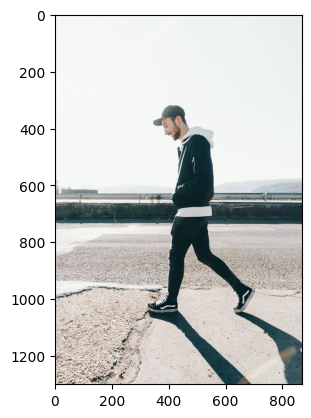

a man in a black shirt stands with a beach . <STOP> 

In [132]:
test_model("../data/misc/man.jpeg")

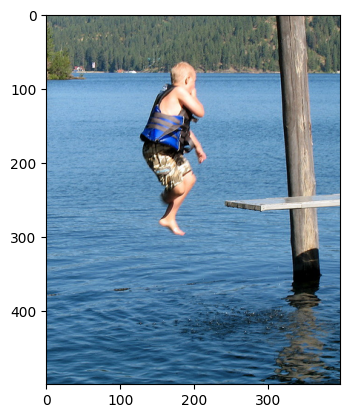

a man in a blue shirt and blue shorts and a paddle face by a beach . <STOP> 

In [128]:
test_model(folder_path + data.iloc[1300]["image"])

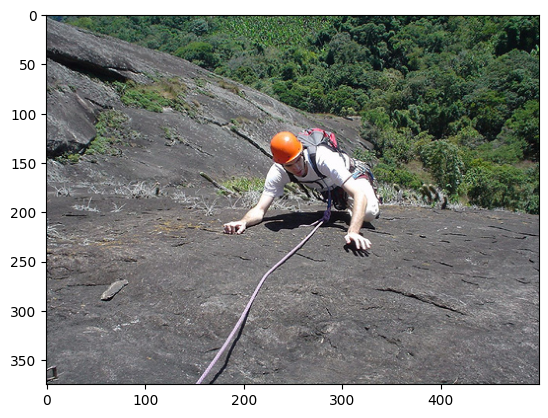

a man in a blue vest and purple vest standing in a cave . <STOP> 

In [129]:
test_model(folder_path + data.iloc[2000]["image"])

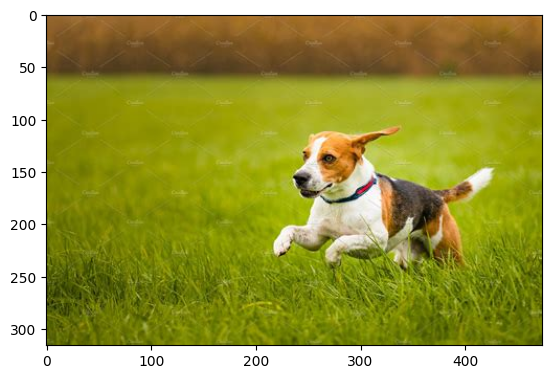

a small dog running in the distance and a red object in front of a big field . <STOP> 

In [134]:
test_model("../data/misc/dog_run")